<a href="https://colab.research.google.com/github/unknown-jun/wanted_pre_onboarding/blob/main/Week2_1_assignment_ta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Introduction](https://riverkangg.github.io/nlp/nlp-bertWordEmbedding/)
## Why BERT embeddings?
이 포스팅에서는 BERT를 사용하여 텍스트 데이터에서 특정, 즉 단어 및 문장 임베딩 벡터를 추출하는 방법을 설명하고자한다. 우선 단어와 문장 임베딩 벡터로 무엇을 할 수 있을까?
- 임베딩은 키워드/검색어 확장, 의미 찾기 및 정보 검색에 유용하다. 예를 들어, 고객의 질문(검색)을 이미 답변된 질문이나 잘 문서화된 검색과 비교하려는 경우, 임베딩 벡터를 사용하면 키워드나 구문이 겹치지 않더라도 고객의 의도와 일치하는 결과를 찾을 수 있다.
- 임베딩 벡터는 다운 스트림 모델에서 고품질 입력 피처로 사용된다. LSTM 또는 CNN과 같은 NLP 모델에는 숫자 벡터 형식의 입력이 필요하며, 이는 일반적으로 어휘 및 품사와 같은 기능을 숫자로 변환하는 것을 의미한다. 이전에는 단어가 고유한 인덱스값(원-핫 인코딩)으로 표현되거나 Word2Vec 또는 Tasttect와 같은 모델에서 생성된 고정 길이 임베딩과 어휘 단어가 일치하는 neural word embeddings으로 더 유용하게 표현되었다.

BERT는 Word2Vec과 같은 모델에 비해 문맥을 고려한 임베딩이 된다는 장점이 있다. Word2Vec은 단어가 나타나는 문맥에 관계없이 각 단어가 고정된 표현을 가지지만, BERT는 주변 단어에 의해 동적으로 변하는 단어표현을 생성한다. 예를 들어 다음 두 문장이 주어진다면:
- 배를 타고 여행을 간다.
- 추석에 먹은 배가 맛있었다.

Word2Vec은 두 문장의 "배"라는 단어에 대해 동일한 단어 임베딩을 생성하는 반면 BERT에서는 "배"에 대한 단어 임베딩이 문장마다 다르다. 다의어를 포착하는 것 외에도 문맥에 맞는 단어 임베딩은 다른 형태의 정보를 알아낸다. 결과적으로 더 정확한 feature representation이 가능하며 이에 따라 모델 성능이 향상된다.

## 1. Loading Pre-Trained BERT
Hugging Face(이 라이브러리에는 OpenAI의 GPT 및 GPT-2와 같은 사전 학습된 다른 언어 모델에 대한 인터페이스를 포함)로 BERT용 PyTorch 인터페이스를 설치힌다.

이 튜토리얼에서는 PyTorch를 사용한다. high-level API는 사용하기 쉽지만 작동방식에 대한 통찰력을 제공하지 않고, tensorflow는 설정해야할 사항이 많다.(하지만 BERT를 사용하다보면 tensorflow를 사용할 일이 많다.)

In [1]:
!pip install transformers

BERT 모델은 Google의 사전 학습된 모델로 다양한 장르의 도서가 10,000개 이상 포함된 데이터 세트인 Wikipedia, Book Corpus에서 긴 시간 동안 학습된 것이다. 이 모델은 NLP의 여러 과제에서 최고점수를 달성했다.

`transformers`는 BERT를 다른 작업(토큰 분류, 텍스트 분류 등)에 적용하기 위해 여러 클래스를 제공한다. 이번 포스팅에서는 단어 임베딩이 목적이기 때문에, 출력이 없는 기본`BertModel`을 사용한다.

In [2]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activiate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt

# Load pre-trained model tokenizer(vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

## 2. Input Formatting
BERT는 특정 형식의 입력 데이터를 필요로 한다.
1. **special token**`[sep]`은 문장의 끝을 표시하거나 두 문장을 분리할 때 사용한다.
2. **special token**`[CLS]`은 문장을 시작할 때 사용한다. 이 토큰은 분류문제에서 사용되지만, 어떤 문제를 풀더라도 입력해야 한다.
3. BERT에서 사용되는 단어사전에 있는 토큰
4. BERT 토크나이저의 토큰에 대한 **Token ID**
5. 시퀀스에서 어떤 요소가 토큰이고 패딩 요소인지를 나타내는 **Mask ID**
6. 다른 문장을 구별하는데 사용되는 **Segment ID**
7. 시퀀스 내에서 토큰 위치를 표시하는 데 사용되는 **Positional Embeddings**

다행히도 `transformers`인터페이스는 위의 모든 사항을 처리한다.(tokenizer.encode_plus 함수 사용). 하지만 이 포스팅은 BERT 작업을 소개하기 위한 것이므로 (대부분)수동으로 이러한 단계를 진행한다.

### 2.1. Special Tokens
-----
BERT는 하나 또는 두개의 문장을 입력으로 사용할 수 있고, 특수 토큰 `[SEP]`으로 구분한다. `[CLS]`토큰은 항상 텍스트 시작 부분에 나타나며 분류 문제를 해결할 때만 사용되지만 다른 문제를 풀더라도 입력은 무조건 해야 한다.

In [3]:
# 2 Sentence input 예시
sent1 = '드디어 내일 주말이다. '
sent2 = '날씨가 맑으면 공원에 가야겠다.'
cls_token= '[CLS] '
sep_token= '[SEP] '

cls_token + sent1 + sep_token + sent2

'[CLS] 드디어 내일 주말이다. [SEP] 날씨가 맑으면 공원에 가야겠다.'

In [4]:
# 1 Sentence input 예시
cls_token + sent1 + sep_token

'[CLS] 드디어 내일 주말이다. [SEP] '

### 2.2. Tokenization
-----
BERT는 자체 토크나이저를 제공한다.BERT의 토크나이저는 WordPiece 모델을 사용한다. 이 모델은 언어데이터에 가장 적합한 개별 문자, 하위 단어(subwords) 및 단어의 고정 크기 단어사전를 탐욕스럽게(greedily) 만든다. BERT 토크나이저는 30,000개로 단어사전의 크기를 제한하기 때문에, WordPiece 모델은 영어 코처스에서 최대 30,000개의 가장 일반적인 단어 및 하위 단어로 단어사전을 만든다.
- 한국어의 경우 영어에 비해 학습된 텍스트의 갯수가 현저히 적다.

In [5]:
text= "임베딩을 시도할 문장이다."
marked_text= "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text= tokenizer.tokenize(marked_text)

print(tokenized_text)

['[CLS]', '임', '##베', '##딩', '##을', '시', '##도', '##할', '문', '##장이', '##다', '.', '[SEP]']


단어사전에는 다음 네가지가 포함된다.
1. 전체 단어
2. 단어의 앞에 또는 분리되어 발생하는 하위단어("embeddings"에서와 같이 "em"에는 "got get em"에서와 같이 독립형 문자 "em"시퀀스와 동일한 벡터가 할당 됨)
3. 단어 앞에 있지 않은 하위 단어. 이 경우를 나타내기 위해'##'이 앞에 붙는다.
4. 개별 문자

이 모델에서 단어를 토큰화하기 위해 토크나이저는 먼저 전체 단어가 어휘에 있는지 확인한다. 그렇지 않은 경우 단어를 어휘에 포함된 가능한 가장 큰 하위단어로 나누고, 하위 단어로도 나뉘어지지 않는다면 개별 문자로 분해한다. 이 때문에 우리는 항상 최소한 개별 문자의 모음으로 단어를 표현할 수 있다.

다시 말하자면, 사전에 없는 단어를 'OOV' 또는 'UNK'와 같은 토큰을 주는 대신, 어휘에 포함되지 않은 단어는 사전에 있는 하위 단어 및 문자 토큰으로 분해한다.

위의 결과를 보면 단어사전에 없는 "임베딩"이라는 단어는 ['임', '##베','##딩']으로 분할된다. 이러한 하위 단어 임베딩 벡터를 평균하여 원래 단어에 대한 근사 벡터를 생성할 수도 있다.

텍스트를 토큰으로 분리한 후, 토큰화된 문자 리스트를 숫자리스트로 바꿔야 한다.

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text= "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text= tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens= tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
After         1,258
stealing     11,569
money         1,948
from          1,121
the           1,103
bank          3,085
vault        13,454
,               117
the           1,103
bank          3,085
r               187
##ob         12,809
##ber         3,169
was           1,108
seen          1,562
fishing       5,339
on            1,113
the           1,103
Mississippi   5,201
river         2,186
bank          3,085
.               119
[SEP]           102


### 2.3. Segment ID
-----
BERT는 두 문장을 구별하기 위해 1과 0을 사용하여 문장 쌍을 학습하고 예상한다. 즉, 토큰화된 텍스트의 각 토큰에 대해 어떤 문장에 속하는지 지정해야 한다: 문장 0(0 리스트) 또는 문장1(1 리스트). 우리의 목적을 위해 단일 문장 입력에는 1 리스트만 필요하므로 입력 문장의 각 토큰에 대해 1로 구성된 벡터를 생성한다.

In [7]:
# Mark each of the 29 tokens as belonging to sentence "1"
segments_ids= [1] * len(tokenized_text)

print(segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## 3. Extracting Embeddings

### 3.1.Running BERT on our text
-----
데이터를 토치 텐서(torch tensor)로 변환하고 BERT 모델을 호출해야 한다. BERT PyTorch 인터페이스에서는 데이터 형태가 Python list가 아닌 토치 텐서가 필요하므로 이번 장에서 변환한다.- 이 작업은 형태나 데이터를 변경하지 않는다.

In [8]:
# Convert inputs to PyTorch tensors
tokens_tensor= torch.tensor([indexed_tokens])
segments_tensor= torch.tensor([segments_ids])

In [9]:
tokens_tensor, segments_tensor

(tensor([[  101,  1258, 11569,  1948,  1121,  1103,  3085, 13454,   117,  1103,
           3085,   187, 12809,  3169,  1108,  1562,  5339,  1113,  1103,  5201,
           2186,  3085,   119,   102]]),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]))

`from_pretrained`를 호출하면 웹에서 모델을 다운로드한다. `bert-base-multilingual-case`를 로드하면 로깅에 인쇄된 모델의 정의를 볼 수 있다. 이 모델은 12개의 레이러로 구성된 심층 신경망이다.

`model.eval()`은 학습 모드가 아닌 평가 모드로 모델을 설정한다. 이 경우 평가 모드는 훈련에 사용되는 드롭아웃 정규화(dropout regularization)를 해제한다.

*Side note: torch.no_grad는 PyTorch가 순방향 패스(forward pass)를 하는 동안 컴퓨팅 그래프를 구성하지 않도록한다(여기서 backprop를 실행하지 않기 때문에). 메모리 소비를 줄이고 작업 속도를 약간 높일 수 있다.*

In [10]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-cased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers
with torch.no_grad():

    outputs= model(tokens_tensor, segments_tensor)

    # Evaluation the model will return a different number of objects based on
    # how it's configured in the 'from_pretrained' call earlier. In this case,
    # because we set 'output_hidden_states=True', the third item will be the 
    # hidden states from all layers. 
    hidden_states= outputs[2]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 3.2. Understanding the Output
-----
`hidden_states`개체에 저장된 이 모델의 전체 은닉층은 약간 복잡하다. 이 개체에는 다음 순서로 4개의 차원이 있다.
1. The layer number (13 layers)
2. The batch number (1 sentence)
3. The word / token number (36 tokens in our sentence)
4. The hidden unit / feature number (768 features)

BERT는 12개의 레이어만을 가지고 있지만 입력 임베딩을 고려한 구조이다. 즉 첫번째 요소는 입력 임베딩이고 나머지는 BERT의 12개 레이어 각각의 결과이므로 13개이다.

In [11]:
print('Number of layers:', len(hidden_states), '  (inital embeddings + 12 BERT layers)')
layer_i= 0

print('Number of batches:', len(hidden_states[layer_i]))
batch_i= 0

print('Number of tokens:', len(hidden_states[layer_i][batch_i]))
token_i= 0

print('Number of hidden units:', len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (inital embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 24
Number of hidden units: 768


주어진 레이어와 토큰에 대한 값의 범위가 모든 레이어와 토큰에 상당히 유사하다는 것을 알 수 있다. 대부분의 값이 [-2.5, 2.5] 사이에 있다.

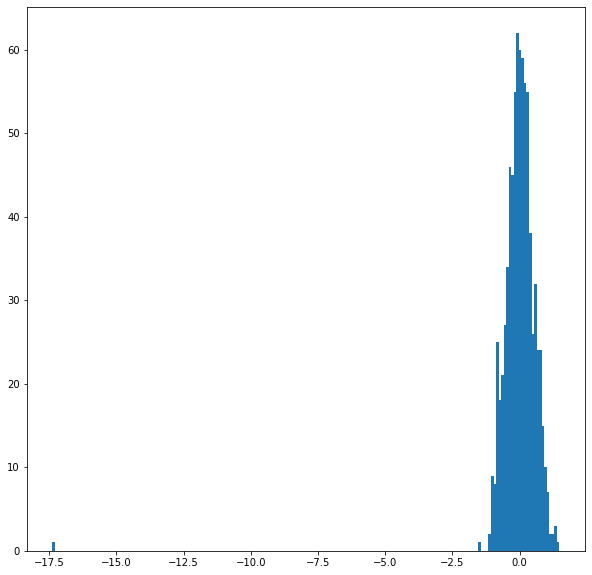

In [12]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

레이어별로 값을 그룹화하는 것이 모델에 적합하지만, 단어 임베딩을 위해 토큰별로 그룹화한다.

현재 차원:
```
[# layers, # batches, # tokens, # features]
```

원하는 차원:
```
[# tokens, # layers, # features]
```
다행히 PyTorch에는 텐서 차원을 쉽게 재배열 할 수 있는 `permute`함수가 포함되어 있다.

그러나 첫번째 차원은 현재 Pyton list이다!


In [13]:
# hidden_states' is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 24, 768])


레이어를 결합해서 하나의 큰 텐서를 만든다.

In [14]:
# Concatenate the tensors for all layers. We use 'stack' here to
# create a new dimension in the tensor.
token_embeddings= torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 24, 768])

"batches" 차원은 필요하지 않으므로 제거한다.

In [15]:
# Remove dimension 1, the "batches".
token_embeddings= torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 24, 768])

마지막으로 `permute`를 사용하여 "layers" 및 "tokens"차원을 전환할 수 있다.

In [16]:
# Swap dimensions 0 and 1
token_embeddings= token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([24, 13, 768])

### 3.3. Creating word and sentence vectors form hidden states
-----
은닉층으로 무엇을 할 수 있을지 알아보자. 각 토큰에 대한 개별 벡터 또는 전체 문장의 단일 벡터 표현을 얻고 싶지만, 입력의 각 토큰에 대해 각각 768 크기의 13개의 개별 벡터가 있다.

개별 벡터를 얻으려면 일부 레이어 벡터를 결합해야 한다. 어떤 레이어 또는 레이어 조합이 최상의 표현을 제공할 수 있을까?

안타깝게도 명확한 답은 없다.하지만 몇 가지 합리적인 접근 방식을 시도해보고, 추가로 살펴볼 수 있는 몇 가지 유용한 리소스를 소개한다.

##### Word Vectors
두 가지 방법으로 단어 벡터를 만들어보자.  
먼저 마지막 4개의 레이어를 **연결하여(concatenate)** 토큰 당 단일 벡터를 제공한다. 각 벡터의 길이는 `4 x 768 = 3072`다.

In [17]:
# Stores the token vectors, with shape [36 x 3,072]
token_vecs_cat = []

# 'token_embeddings' is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # 'token' is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) 
    # from the last four layers.
    # Each layer vector is 768 values, so 'cat_vec' is length 3,072
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

    # Use 'cat_vec' to represent 'token'.
    token_vecs_cat.append(cat_vec)

print('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 24 x 3072


다른 방법으로 마지막 4개의 레이어를 합산하여**(summing)** 단어 벡터를 만든다.

In [18]:
# Stores the token vectors, with shape [36 x 768]
token_vecs_sum = []

# 'token_embeddings' is a [36 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # 'token' is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)

    # Use 'sum_vec' to represent 'token'.
    token_vecs_sum.append(sum_vec)

print('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 24 x 768


##### Sentence Vectors
전체 문장에 대한 단일 벡터를 얻기 위해 여러 application-dependent 전략이 있지만, 간단한 접근 방식은 단일 768크기의 벡터를 생성하는 각 토큰의 두번째에서 마지막 숨겨진 레이어를 평균내는 것이다.

In [19]:
# 'hidden_states' has shape [13 x 1 x 36 x 768]

# 'token_vecs' is a tensor with shape [36 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 36 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

print('Our final sentence embedding vector of shape:',sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


### 3.4 Confirming contextually dependent vectors
-----
이러한 벡터의 값을 실제로 상황에 따라 달라지는지 확인하기 위해, 'bank'라는 단어의 여러 인스턴스를 살펴보자

In [20]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 After
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 r
12 ##ob
13 ##ber
14 was
15 seen
16 fishing
17 on
18 the
19 Mississippi
20 river
21 bank
22 .
23 [SEP]


'bank'라는 인스턴스는 7, 17에 있다. 이 분석에서는 마지막 4개의 레이어를 합산하여 만든 단어 벡터를 사용한다. 벡터를 출력하여 비교해 볼 수 있다.

In [21]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([-4.1573,  1.7935, -2.6768,  3.3647,  1.6400])
bank robber   tensor([-2.0299, -0.9155, -4.2468,  4.2540,  2.1868])
river bank    tensor([ 3.1898, -0.4442, -1.9258, -0.4348,  2.5461])


값이 다른 것을 볼 수 있지만 더 정확한 비교를 위해 벡터 간의 코사인 유사성을 계산한다.

In [22]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.90
Vector similarity for *different* meanings:  0.68


# Week2_1 Assignment

# [BASIC](#Basic)
- BERT 모델의 hidden state에서 **특정 단어의 embedding을 여러 방식으로 추출 및 생성**할 수 있다.

# [CHALLENGE](#Challenge)
- **cosine similarity 함수를 구현**할 수 있다. 
- **단어들의 유사도**를 cosine similarity로 비교할 수 있다. 

# [ADVANCED](#Advanced)
- 문장 embedding을 구해 **문장 간 유사도**를 구할 수 있다.

### Reference
- [BERT word embedding & sentence embedding tutorial 영문 블로그](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#33-creating-word-and-sentence-vectors-from-hidden-states)

In [23]:
import os
import sys
import pandas as pd
import numpy as np 
import torch
import random

## Basic
### BERT 모델과 토크나이저 로드   
- 두 사람의 대화에서 (단어 및 문장의) embedding을 생성하고자 한다. 아래 대화를 BERT 모델에 입력해 출력값 중 "hidden states"값을 가져오자.
- `Hidden States`는 3차원 텐서를 가지고 있는 list 타입이다. List에는 BERT 모델의 각 layer마다의 hidden state 3차원 텐서를 갖고 있으며 각 텐서는 (batch_size, sequence_length, hidden_size) shape을 가진다. BERT-base 모델은 12 layer를 갖고 있고 이와 별도로 Embedding Layer 1개를 더 갖고 있기 때문에 `len(hidden states)`는 13개가 된다. 
    - batch_size: 학습 시 설정한 배치 사이즈. 또는 BERT 모델에 입력된 문장의 개수
    - sequence_length: 문장의 token의 개수. 
    - hidden size: token의 embedding size 
- Reference
    - [BertTokenizer.tokenize() 함수의 매개변수 설명](https://huggingface.co/transformers/v3.0.2/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.__call__)
    - [BERTModel.forward() 함수의 매개변수 및 리턴 값 설명](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel.forward)

In [24]:
from transformers import BertTokenizer, BertModel
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-cased')
model_bert = BertModel.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
normal_person= ['What do you do when you have free time?']
nerd= ['I code. code frees my minds, body and soul.']
normal_person.append('(what a nerd...) coding?')
nerd.append("Yes. coding is the best thing to do in the free time.")

for i in range(len(normal_person)):
    print(f"Normal Person asked: {normal_person[i]}")
    print(f"Nerd answers: {nerd[i]}")

Normal Person asked: What do you do when you have free time?
Nerd answers: I code. code frees my minds, body and soul.
Normal Person asked: (what a nerd...) coding?
Nerd answers: Yes. coding is the best thing to do in the free time.


In [26]:
# 매개변수 설명
# truncation <- max_len 넘어가지 않도록 자르기
# padding <- max(seq_len, max_len) zero padding
# return_tensors <- return 2d tensor

inputs= tokenizer_bert(
    text= normal_person,
    text_pair= nerd,
    truncation= True,
    padding= "longest",
    return_tensors= 'pt'
)

print(inputs['input_ids'].shape)

torch.Size([2, 28])


In [27]:
# decoding
for i in range(len(inputs['input_ids'])):
    print(f"Coversation {i} -> '{tokenizer_bert.decode(inputs['input_ids'][i])}' ")

Coversation 0 -> '[CLS] What do you do when you have free time? [SEP] I code. code frees my minds, body and soul. [SEP] [PAD] [PAD]' 
Coversation 1 -> '[CLS] ( what a nerd... ) coding? [SEP] Yes. coding is the best thing to do in the free time. [SEP]' 


In [28]:
# "code" 단어의 token id(각 단어에게 고유하게 주어진 id)를 출력
tokenizer_bert.encode('code', add_special_tokens=False)

[3463]

In [29]:
if torch.cuda.is_available():
    device= torch.device('cuda')
else:
    device= torch.device('cpu')

print(device)

cuda


In [30]:
# 입력 데이터와 BERT 모델을 "GPU" 장치로 로드함
inputs= inputs.to(device)
model_bert.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [31]:
# 입력 데이터를 BERT 모델에 넣어 출력값을 가져옴
outputs= model_bert(
    **inputs,
    output_hidden_states=True
)

In [32]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [33]:
hidden_states= outputs['hidden_states']
print(f'# layers: {len(hidden_states)}')
print(f"tensor shape in each layer: {hidden_states[-1].shape}")

# layers: 13
tensor shape in each layer: torch.Size([2, 28, 768])


###  Q1. 1번째 sequence (문장)에서 "code"라는 단어의 인덱스를 모두 반환하라.
- "code" 단어는 총 2개 존재 

In [34]:
def get_index(seq, word):
    code_encode = tokenizer_bert.encode(word, add_special_tokens=False)
    index= (seq==code_encode[0]).nonzero()
    return index

# input
# seq1: 1번째 sequence
# token: 단어
seq1= inputs['input_ids'][0]
token= "code"

# output
token_index= get_index(seq1, token)
print(token_index)

tensor([[13],
        [15]], device='cuda:0')


### Q2. 1번째 sequence의 1번째 "code" 토큰의 embedding을 여러가지 방식으로 구하고자 한다. BERT hidden state를 다음의 방식으로 인덱싱해 embedding을 구하라
- 1 layer
- last layer
- sum all 12 layers
- sum last 4 layers
- concat last 4 layers
- average last 4 layers

In [35]:
index= token_index[0]

# 1 layer
first_layer_emb= hidden_states[1][0, index.item(), :]
print(first_layer_emb.shape)

# last layer
last_layer_emb = hidden_states[-1][0, index.item(),:]
print(last_layer_emb.shape)

# sum all 12 layers
sum_all_layer_emb = sum([hs[0, index.item(),:] for hs in hidden_states])
print(sum_all_layer_emb.shape)

# sum last 4 layers
sum_last4_layer_emb = sum([hs[0, index.item(),:]for hs in hidden_states[-4:]])
print(sum_last4_layer_emb.shape)

# concat last 4 layers
concat_last4_layer_emb = torch.cat([hs[0, index.item(),:]for hs in hidden_states[-4:]], dim=0)
print(concat_last4_layer_emb.shape)

# mean last 4 layers
mean_last4_layer_emb = sum([hs[0, index.item(),:]for hs in hidden_states[-4:]]) /4
print(mean_last4_layer_emb.shape)

torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072])
torch.Size([768])


### Q3. `sum_last_four_layer` 방식으로 1번째 sequence의 2개의 "code" 토큰 사이의 코사인 유사도를 계산하라

In [36]:
def cosine_similarity_manual(x, y, small_number=1e-8):
  from scipy.spatial.distance import cosine
  result = 1 - cosine(x.cpu().detach().numpy(),
                      y.cpu().detach().numpy())

  return result

# input
# x: 1번째 sequence의 1번째 "code"의 sum_last_four_layer 방식 embedding
# y: 1번째 sequence의 2번째 "code"의 sum_last_four_layer 방식 embedding
x = sum([hs[0, token_index[0].item(),:]for hs in hidden_states[-4:]])
y = sum([hs[0, token_index[1].item(),:]for hs in hidden_states[-4:]])

# output
score = cosine_similarity_manual(x, y)
print(score)

0.8400022983551025


### Q4. 2번째 sequence에서 "coding"이라는 토큰의 위치를 반환하라

In [37]:
# Q1과 동일한 문제 

# input
# seq1: 2번째 sequence
# token: 단어
seq2 = inputs['input_ids'][1]
token = "coding"

# output
# Q1에서 구현한 함수 사용
token_index = get_index(seq2, token)
print(token_index)

tensor([[10],
        [15]], device='cuda:0')


### Q5. `concat_last4_layer_emb` 방식으로 2번째 sequence의 2개의 "coding" 토큰 사이의 코사인 유사도를 계산하라

In [38]:
# Q3과 동일한 문제

# input
# x: 2번째 sequence의 1번째 "coding"의 concat_last4_layer_emb
# y: 2번째 sequence의 2번째 "coding"의 concat_last4_layer_emb
x = torch.cat([ hs[1, token_index[0].item(), :] for hs in hidden_states[-4:] ], dim=0)
y = torch.cat([ hs[1, token_index[1].item(), :] for hs in hidden_states[-4:] ], dim=0)

# output
# Q3에서 구현한 함수 사용
score = cosine_similarity_manual(x, y)
print(score)

0.8681784272193909


### Q6. 2번째 sequence에서 랜덤하게 토큰 하나를 뽑아보자. 그 랜덤 토큰과 2번째 sequence의 2번째 "coding" 토큰의 코사인 유사도를 계산해보자

In [50]:
hidden_states[0].shape[1]

28

In [59]:
# input
# random_idx: random 모듈 사용하여 뽑은 랜덤 토큰의 인덱스
# random_word: random_idx에 해당하는 단어
# x: 2번째 sequence의 2번째 "coding" 토큰의 concat_last4_layer_emb
# y: 랜덤 토큰의 concat_last4_layer_emb

random_idx = random.randint(0,hidden_states[0].shape[1])
random_token_id = inputs['input_ids'][-1][random_idx].item()
random_word = tokenizer_bert.decode([random_token_id])
print('Other word:', random_word)

x = torch.cat([ hs[1, token_index[1].item(), :] for hs in hidden_states[-4:] ], dim=0)
y = torch.cat([ hs[1, random_idx, :] for hs in hidden_states[-4:] ], dim=0)

# output
# Q3에서 구현한 함수 사용
score = cosine_similarity_manual(x, y)
print(score)

Other word: what
0.5863762497901917


## Advanced

### Q7. 1번째 sequence와 2번째 sequence의 문장 유사도를 구해보자. 문장의 엠베딩은 마지막 레이어의 첫번째 토큰 ('[CLS]')으로 생성한다.

In [60]:
# input
# x: 1번째 sequence의 embedding
# y: 2번째 sequence의 embedding
x = hidden_states[-1][0, 0, :]
y = hidden_states[-1][1, 0, :]

# output
# Q3에서 구현한 함수 사용
score =  cosine_similarity_manual(x, y)
print(score)

0.7969229817390442
